## Trying to get un-stuck on a seemingly simple ODE  problem

In [1]:
using JuMP
using Ipopt
using DataFrames, CSV
using Plots
using DifferentialEquations
using Distributions
using NLsolve

### Overview
This notebook details a "simple" procurement auction equilibrium computation, for auctions of the form described [here](https://scholar.harvard.edu/files/vasserman/files/bv_sept2019.pdf).

For some shorter notes working out the math for this example in full see [here](https://github.com/shoshievass/PublicFiles/blob/master/Julia/baseline_equilibrium_derivation_risk_aversion_note.pdf). For a better high-level explanation of what's going on, aimed at extending this model to a two-dimensional type version, see [here](https://github.com/shoshievass/PublicFiles/blob/master/Julia/two_type_equilibrium_note.pdf).

I present the ODE and a working solution, using an upper bound as an initial condition. I then try to solve the ODE in the "inverse", using a guessed lower bound as an initial condition. 

The reason for trying to solve the inverse problem is that I ultimately want to solve a boundary-value problem where two ODEs of this form need to be solved simultaneously subject to having the same values at the boundaries. One way to try to solve the boundary value problem is to use a shooting algorithm in which I solve the two inverse ODE problems with guessed initial values and check if they match at the upper boundary.

Currently, the reverse and inverse problems doesn't work -- most likely for numerical reasons that I don't understand.

### The ODE

The ODE problem maps a bounded interval of "types" $\alpha \in \left[ \underline{\alpha}, \overline{\alpha} \right]$ to "scores" $s \in \left[ \underline{s}, \overline{s} \right]$ according to the differential equations:

$$
s'(\alpha) = \frac{f(\alpha)}{1-F(\alpha)} \cdot \frac{V(s, \alpha, p)}{V'(s , \alpha, p)}
$$

Here:
- $f(\alpha)$ and $F(\alpha)$ are the pdf and cdf of the distrubiton with which the types $\alpha$ are distributed -- which we will assume is a uniform distribution for simplicity. 

- That is, $f(x) = \frac{1}{\overline{\alpha} - \underline{\alpha}}$ and $F(x) = \frac{x - \underline{\alpha}}{\overline{\alpha} - \underline{\alpha}}$ 

- $ V(s , \alpha, p) $ is a "value function" evaluated at $s, \alpha$ and a vector of parameters $p$. More details on this in a bit.

- $V'(s , \alpha, p) = \frac{\partial V}{\partial s} V(s , \alpha, p)$ is the derivative of the value function with respect to s.

In [2]:
function ds_da_ode( s, alpha, params)
    
    f_over_oneMinusF = f_over_one_minus_F_uniform(alpha, 0.5, 2.0)

    V_over_dV = getFracVdV(s, alpha, params)
    
    ds_da = f_over_oneMinusF * V_over_dV; # Note: this should be a scalar
    
    return(ds_da)

end

ds_da_ode (generic function with 1 method)

#### More Details

- Note that $\frac{f(\alpha)}{1-F(\alpha)}$ must be zero outside the support of $\alpha$. We define this below.

- The value function here is a bit complicated -- it requires solving a (simple) constrained quadratic formula to define:

$$
\begin{array}{c}V(s , \alpha, \mathbf{p}) = \arg\max\limits_{\{{b_t}(s)\}_t} \left[1-\exp \left(\sum_{t=1}^{T} \frac{\gamma^{2} \sigma_t^{2}}{2}\left(b_{t}(s)-\alpha c_{t}\right)^{2}-\gamma q_{t}^{a}\left(b_{t}(s)-\alpha c_{t}\right)\right)\right] \\ \text { s.t. } \sum_{t=1}^{T} b_{t}(s) q_{t}^{e}=s \\ \text { and } b_{t} \geq 0 \text { for each } t\end{array}
$$

where the parameter vector $ \mathbf{p}$ includes a whole bunch of parameters: $$ \mathbf{p} = \Big\{ \gamma, \{q_{t}^{a}\}_t,  \{q_{t}^{e}\}_t,\{\sigma_{t}^{2}\}_t \text{ and }  \{c_{t}\}_t  \Big\}$$

But we can solve this problem numerically for the vector of "bids" $b_{t}^{\ast}(s)$. Note that the optimal $b^{\ast}$ solution depends not just on $s$ but on $\alpha$ and all of the other parameters too, but we will keep everything except $s$ and $\alpha$ fixed for our ODE computation and for each $\alpha$ we will choose a single $s$.

In [3]:
function f_over_one_minus_F_uniform(z, a, b)
    if z <= a 
        out = 0
    elseif z >= b
        out = 0
    else 
        out =  1.0/(b - z) 
    end
end

function getBidStar( s, alpha, params)
# Compute the optimal unit bid vector for each score by solving the quadratic optimization problem

    gamma, c, q_e, q_a, sigma_sq  = params
    
    T = length(q_e)
    if sum(sigma_sq) > 0

        m = Model(Ipopt.Optimizer)
        set_optimizer_attribute(m, "print_level", 0)

        @variables m begin
        b[i=1:T] >= 0
        end

        @objective( m,
                    Max,
                    (sum((q_a[i] * (b[i] - alpha*c[i]) - (gamma / 2) * sigma_sq[i] * (b[i] - alpha*c[i])^2) for i=1:T ))
                 )

              @constraint(m, sum( b[i] * q_e[i] for i=1:T ) == s)

           optimize!(m)

           b_min = value.(b)
   else
       (maxitem,maxindex) = findmax(q_a./q_e)
       b_min = zeros(T)
       b_min[maxindex] = s/q_e[maxindex]
   end

    return b_min

end


function getDbDs(s, alpha, b, params)
#     %Computes anayltical derivative of the optimal bid function of item t
#     % w.r.t. score s given alpha
    
    gamma, c, q_e, q_a, sigma_sq  = params

    T = length(q_e)
    pos_b = [ifelse(b[t] > 0, 1, 0) for t=1:T]

    if (sum(sigma_sq) > 0)
        denom = 1.0/(sum((q_e[t]^2 * pos_b[t]) / sigma_sq[t] for t in 1:T))
        db_ds = [((q_e[t] * pos_b[t] / sigma_sq[t]) * denom) for t in 1:T]'
    else
        db_ds = [ifelse(b[t] > 0, (1.0/q_e[t]), 0) for t=1:T]'
    end

    return(db_ds)

end

function getFracVdV(s, alpha, params)
    
   gamma, c, q_e, q_a, sigma_sq  = params
                                                                
    b = getBidStar( s, alpha, params)
    db_ds = getDbDs( s, alpha, b, params)

    b_min_c = b - (alpha*c);

    profit_ce = (q_a' * b_min_c) - (gamma)*0.5 * ((sigma_sq .* b_min_c)' * b_min_c)
    profit_term = exp(gamma*profit_ce) - 1; 
    
    dce = db_ds * ((gamma .* q_a) - (gamma^2 .* sigma_sq .* b_min_c) );
    
    V_over_dV = profit_term / dce;
    
    return(V_over_dV)
    
end



getFracVdV (generic function with 1 method)

### Adding a Boundary Condition

To fully define this ODE problem we need an initial condition. For this problem, there is one point at which we know the solution: the "right" boundary.

From the economic theory, we must have the highest type of bidder, $\overline{\alpha}$ gets a value of zero at the solution: $V(s(\overline{\alpha}), \overline{\alpha}, p) = 0.$

Because $V(s, \alpha, p)$ doesn't have a closed form solution, we must solve for this upper bound numerically as well, by searching over the values of $s$ to find:

$$
\overline{s} = \arg\min\limits_{s} \big\{s : V( s, \overline{\alpha}, p) = 0 \big\}
$$

In [10]:
qa = [1.0; 1.0];
qe = [1.0; 1.0];
c0 = [0.0; 0.0];
sigmasq = [0.0, 0.0];
gam = 1.0;
params = [gam, c0, qe, qa, sigmasq]

s = 30
@show getFracVdV(s, 1.0, params)
@show v_over_dv = (1-exp(-s))/(exp(-s));

getFracVdV(s, 1.0, params) = 1.0686474581523463e13
v_over_dv = (1 - exp(-s)) / exp(-s) = 1.068647458152346e13


1.068647458152346e13

In [17]:
function getInsideV(s, alpha, params)
    gamma, c, q_e, q_a, sigma_sq  = params
    
    b = getBidStar( s, alpha, params)    

    b_min_c = b - (alpha*c);

    ce = (q_a' * b_min_c) - (gamma/2) * ((sigma_sq .* b_min_c)' * b_min_c)
end

function getBoundarySMax(alpha_max, params)
    gamma, c, q_e, q_a, sigma_sq  = params
    
    function ce_fun(svec)
        s_max_var = svec[1]
        return getInsideV(s_max_var, alpha_max, params) 
    end
    
    starting_point = alpha_max*1.01*(c' * q_a)

    s_max_sol = nlsolve(ce_fun, [starting_point]; inplace = false)
    return s_max_sol.zero[1]
end

getBoundarySMax (generic function with 1 method)

### Solving an easy example

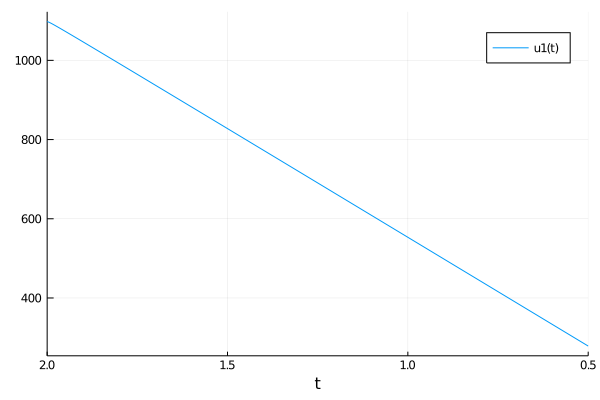

In [20]:
qa = [12; 40];
qe = [10; 50];
c0 = [5;10];
sigmasq = [3, 5];
gam = 1.5;

alpha_max = 2;
alpha_min = 0.5;

alpha_span = (alpha_max,alpha_min);

params = [gam, c0, qe, qa, sigmasq]

s_max_computed = getBoundarySMax(alpha_max, params)

ode_standard_subs(s, p, alpha) = ds_da_ode( s, alpha, params )
ode_standard_prob = ODEProblem(ode_standard_subs, s_max_computed, alpha_span)

sol_standard =  DifferentialEquations.solve(ode_standard_prob, Rosenbrock23(autodiff=false))
plot(sol_standard)

## Solving in Reverse -- Things Break, but Why?

If this is the correct solution, then using the right value for $s(\underline{\alpha})$ should work too....

But it doesn't! I can't figure out why...

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase /Users/svass/.julia/packages/DiffEqBase/bWm8j/src/integrator_interface.jl:343


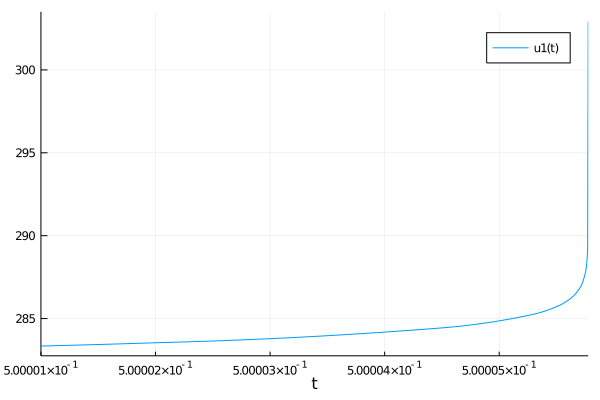

In [42]:
qa = [12; 40];
qe = [10; 50];
c0 = [5;10];
sigmasq = [3, 5];
gam = 1.5;

alpha_max = 2;
alpha_min = 0.5;

# alpha_span = (alpha_max,alpha_min);
alpha_span = ( (alpha_min + 0.000001) , alpha_max);


params = [gam, c0, qe, qa, sigmasq]

s_min_from_forward_solve = sol_standard[end]

s_min_guess = s_min_from_forward_solve

# s_max_computed = getBoundarySMax(alpha_max, params)

ode_reverse_subs(s, p, alpha) = ds_da_ode( s, alpha, params )
ode_reverse_prob = ODEProblem(ode_reverse_subs, s_min_guess, alpha_span)

sol_reverse =  DifferentialEquations.solve(ode_reverse_prob, Rosenbrock23(autodiff=false))
plot(sol_reverse)

## I also tried this with the "inverse" problem -- no luck


In [40]:
function inverse_ds_da_ode( s, alpha, params)
    
    f_over_oneMinusF = f_over_one_minus_F_uniform(alpha, 0.5, 2.0)

    V_over_dV = getFracVdV(s, alpha, params)
    
    da_ds = 1.0 / (f_over_oneMinusF * V_over_dV + 0.00000001); # Note: this should be a scalar
    
    return(da_ds)

end


qa = [12; 40];
qe = [10; 50];
c0 = [5;10];
sigmasq = [3, 5];
gam = 1.5;

alpha_max = 2;
alpha_min = 0.5;

# alpha_span = (alpha_max,alpha_min);
# alpha_span = (alpha_min, alpha_max);


params = [gam, c0, qe, qa, sigmasq]

s_min_from_forward_solve = sol_standard[end]

s_max_computed = getBoundarySMax(alpha_max, params)

s_span = (s_min_from_forward_solve, s_max_computed)


ode_inverse_reverse_subs(alpha, p, s) = inverse_ds_da_ode( s, alpha, params )
ode_inverse_reverse_prob = ODEProblem(ode_inverse_reverse_subs, alpha_min, s_span)

sol_inverse_reverse =  DifferentialEquations.solve(ode_inverse_reverse_prob,
                                            Rosenbrock23(autodiff=false)
                                            )
